In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from pycocotools import coco
import torch, torchvision
import matplotlib.pyplot as plt
import os
import re
from google.colab import drive
import json
import cv2
from google.colab.patches import cv2_imshow
from PIL import Image
from torch.utils.data import Dataset
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

drive.mount('/content/drive/')
save_path = '/content/drive/My Drive/MASC 515/Project/dataset/'

Mounted at /content/drive/


In [2]:
class Louli(Dataset):

    def __init__(self, dir_path, transforms=None):
        self.transforms = transforms
        self.dir_path = dir_path
        self.mask_list = list(sorted(os.listdir(os.path.join(dir_path, "masks"))))
        self.image_list = list(sorted(os.listdir(os.path.join(dir_path, "images"))))

    def __getitem__(self, idx):
        img_path = os.path.join(self.dir_path, "images", self.image_list[idx])
        mask_path = os.path.join(self.dir_path, "masks", self.mask_list[idx])
        image_obj = Image.open(img_path).convert("RGB")
        mask_obj = Image.open(mask_path)
        mask_obj = np.array(mask_obj)
        obj_ids = np.unique(mask_obj)

        # normalize
        image_obj = np.array(image_obj) / 255.0
        #print(image_obj)
        # background has the first id so excluding that
        obj_ids = obj_ids[1:]
        # splitting mask into binaries
        masks_obj = mask_obj == obj_ids[:, None, None]
        #print(masks_obj)
        if self.transforms is not None:
            # Apply transforms to the tensors
            image_tensor = self.transforms(image_obj)
            mask_tensor = self.transforms(mask_obj)

        # Convert PIL images to tensors
        image_tensor = torch.Tensor(np.array(image_tensor)).float()
        # Convert mask to one-hot encoding with 2 channels
        mask_tensor = torch.zeros(2, masks_obj.shape[1], masks_obj.shape[2])
        for i in range(2):  # Iterate over the number of channels (2)
            if i < len(obj_ids):  # Check if there are objects to process
                mask_tensor[i] = torch.Tensor(masks_obj[i])

        return image_tensor, mask_tensor


    def __len__(self):
        return len(self.image_list)

In [3]:

import torchvision.transforms as transforms
# from torchvision.transforms import v2


def get_transform_data(train):
    transform_list = []
    # PIL image to tensor for PyTorch model
    transform_list.append(transforms.ToTensor())
    if train:
        # basic image augmentation techniques
        ## can add few more for experimentation
        transform_list.append(transforms.RandomHorizontalFlip(0.5))
    return transforms.Compose(transform_list)


class CustomTransform:
    def __init__(self, transforms=None):
        self.transforms = transforms

    def __call__(self, image, target):
        for t in self.transforms:
            image, target = t(image, target)
        return image, target

# class CustomTransform:
#     def __init__(self, transforms):
#         self.transforms = transforms

#     def __call__(self, image, target):
#         for t in self.transforms:
#             image, target = t(image, target)
#         return image, target

# transform_train = transforms.Compose([
#     CustomTransform([
#         transforms.ToTensor(),
#         transforms.RandomHorizontalFlip(0.5)
#     ])
# ])

transform_train = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=(-30, 30)),
    transforms.GaussianBlur(kernel_size=3),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=(-30, 30)),
    transforms.GaussianBlur(kernel_size=3),
])

# transform_test = transforms.Compose([
#     CustomTransform([
#         transforms.ToTensor()
#     ])
# ])

In [5]:
def get_traininig_and_test_dataset(datapath):
  # import utils

  # get the traffic data to transform
  # train_dataset = CustomDataset(datapath, get_transform_data(train=True))
  # test_dataset = CustomDataset(datapath, get_transform_data(train=False))

  train_dataset = Louli(datapath, transform_train)
  test_dataset = Louli(datapath, transform_test)

  # img_datapath = os.path.join(datapath, "images")
  # masks_datapath = os.path.join(datapath, "masks")

  # print(masks_datapath)

  # train_dataset = CarvanaDataset(img_datapath, masks_datapath, 1)

  # train test split
  torch.manual_seed(1)
  indices = torch.randperm(len(train_dataset)).tolist()
  train_dataset = torch.utils.data.Subset(train_dataset, indices[:-20])
  test_dataset = torch.utils.data.Subset(test_dataset, indices[-20:])

  # define training and validation data loaders
  train_data_loader = torch.utils.data.DataLoader(
      train_dataset, batch_size=10, shuffle=True, num_workers=0)
  test_data_loader = torch.utils.data.DataLoader(
      test_dataset, batch_size=1, shuffle=False, num_workers=0)

  return train_dataset, test_dataset, train_data_loader, test_data_loader

In [6]:
train_dataset, test_dataset, train_data_loader, test_data_loader = get_traininig_and_test_dataset(save_path)

torch.save(train_dataset, save_path + 'data_pytorch/train_dataset.pt')
torch.save(test_dataset, save_path + 'data_pytorch/test_dataset.pt')
torch.save(train_data_loader, save_path + 'data_pytorch/train_data_loader.pt')
torch.save(test_data_loader, save_path + 'data_pytorch/test_data_loader.pt')


In [11]:


class UNet_new(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=False):
        super(UNet_new, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = (DoubleConv(n_channels, 64))
        self.down1 = (Down(64, 128))
        self.down2 = (Down(128, 256))
        self.down3 = (Down(256, 512))
        self.down4 = (Down(512, 1024))
        factor = 2 if bilinear else 1
        self.down5 = (Down(1024, 2048 // factor))
        self.up1 = (Up(2048, 1024 // factor, bilinear))
        self.up2 = (Up(1024, 512 // factor, bilinear))
        self.up3 = (Up(512, 256 // factor, bilinear))
        self.up4 = (Up(256, 128 // factor, bilinear))
        self.up5 = (Up(128, 64, bilinear))
        self.outc = (OutConv(64, n_classes))

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x6 = self.down5(x5)
        x = self.up1(x6, x5)
        x = self.up2(x, x4)
        x = self.up3(x, x3)
        x = self.up4(x, x2)
        x = self.up5(x, x1)
        logits = self.outc(x)
        return logits

class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        # if you have padding issues, see
        # https://github.com/HaiyongJiang/U-Net-Pytorch-Unstructured-Buggy/commit/0e854509c2cea854e247a9c615f175f76fbb2e3a
        # https://github.com/xiaopeng-liao/Pytorch-UNet/commit/8ebac70e633bac59fc22bb5195e513d5832fb3bd
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)


In [ ]:
# Create CNN model
# model = create_cnn_model(input_shape=(512, 512, 3))
# model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
# model = CNNModel(input_shape)

model = UNet_new(n_channels=3, n_classes=2, bilinear=True)

num_epochs = 10

criterion = nn.BCEWithLogitsLoss()  # Binary Cross-Entropy loss
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Adam optimizer

# Training loop
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

for epoch in range(num_epochs):
    running_loss = 0.0
    total_samples = 0
    y_true = []
    y_pred = []

    for i, (inputs, labels) in enumerate(train_data_loader):

        print(i)

        inputs, labels = inputs.to(device), labels.to(device)
        #print(f"labels BEFORE ANYTHING:{labels}")
        optimizer.zero_grad()

        outputs = model(inputs)
        outputs_softmax = F.softmax(outputs, dim=1)
        loss = criterion(outputs, labels)
        print(f"loss:{loss}")
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        print(f"running_loss:{running_loss}")
        _, predicted = torch.max(outputs, dim=1)

        labels = labels.argmax(dim=1)
        #print(f"labels AFTER:{labels}")  # Convert one-hot to integer labels
        labels = labels.cpu().numpy().flatten()  # Flatten labels
        #print(f"labels AFTER AFTER:{labels}")

        predicted = predicted.cpu().numpy().flatten()  # Flatten predictions
        #print(f"predicted AFTER: {predicted}")

        y_true.extend(labels)
        y_pred.extend(predicted)
        #print(f"y_true: {y_true}")
        #print(f"y_pred!!:{y_pred}")
        # Adjusted calculation to match sizes
        #correct_predictions += (predicted == labels.argmax(dim=1)).sum().item()
        total_samples += labels.size

    #epoch_loss = running_loss / total_samples
    epoch_loss = loss
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    #y_true = y_true.astype(int)
    #y_pred = y_pred.astype(int)
    #print("Unique labels in y_true:", np.unique(y_true))
    #print("Unique labels in y_pred:", np.unique(y_pred))
    #print("Shape of y_true:", y_true.shape)
    #print("Shape of y_pred:", y_pred.shape)

    epoch_dice_score = dice_coefficient(y_true, y_pred)

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Dice Score: {epoch_dice_score:.4f}")


In [ ]:
#from sklearn.metrics import f1_score

model_old = UNet_new(n_channels=3, n_classes=2, bilinear=True)

num_epochs = 10

criterion = nn.BCEWithLogitsLoss()  # Binary Cross-Entropy loss
optimizer = optim.Adam(model_old.parameters(), lr=0.001)  # Adam optimizer



# Training loop
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_old.to(device)

for epoch in range(num_epochs):
    running_loss = 0.0
    #y_true = []
    #y_pred_probs = []
    correct_pixels = 0
    total_pixels = 0
    total_samples = 0

    for i, (inputs, labels) in enumerate(train_data_loader):

        print(i)

        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model_old(inputs)
        outputs_softmax = F.softmax(outputs, dim=1)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs_softmax, dim=1)

        predicted_flat = predicted.view(-1)
        labels_flat = labels[:, 1, :, :].contiguous().view(-1)

        # Adjusted calculation to match sizes
        correct_predictions += (predicted == labels.argmax(dim=1)).sum().item()

        #correct_pixels = (predicted == labels[:, 1, :, :]).sum().item()
        #total_pixels += labels[:, 1, :, :].sum().item()  # Total number of pixels
        total_pixels = labels.numel()
        #y_true.extend(labels[:, 1, :, :].cpu().numpy())
        #y_pred_probs.extend(outputs_softmax[:, 1, :, :].cpu().detach().numpy())

        #y_true.extend(labels_flat.cpu().numpy())
        #y_pred.extend(predicted_flat.cpu().numpy())

        total_samples += labels.size(0)

    epoch_loss = running_loss / total_samples
    #threshold = 0.5
    #f1 = calculate_f1_score(y_true, y_pred_probs)
    pixel_accuracy = correct_pixels / total_pixels

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {pixel_accuracy:.4f}")


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
Epoch [1/10], Loss: 0.2791, Accuracy: 0.0005
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
Epoch [2/10], Loss: 0.0683, Accuracy: 0.0003
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
Epoch [3/10], Loss: 0.0262, Accuracy: 0.0003
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73

In [ ]:
## save the model
torch.save(model_old.state_dict(), save_path + 'model26.pth')

In [14]:
## calling the model that is saved for evaluation

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


model = UNet_new(n_channels=3, n_classes=2, bilinear=True)
model.load_state_dict(torch.load('/content/drive/My Drive/MASC 515/project2/dataset/models/model1500_7.pth', map_location='cpu'))
model.to(device)

UNet_new(
  (inc): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (down1): Down(
    (maxpool_conv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): DoubleConv(
        (double_conv): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=Fals

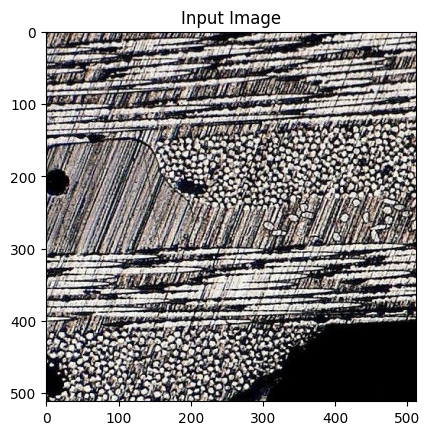

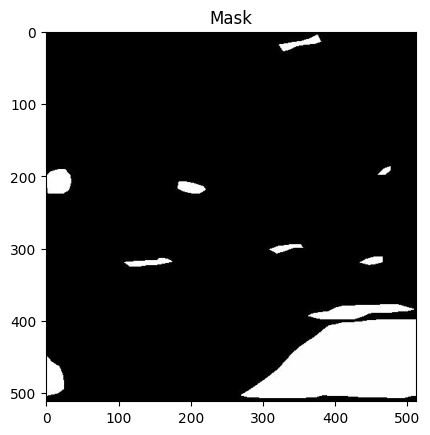

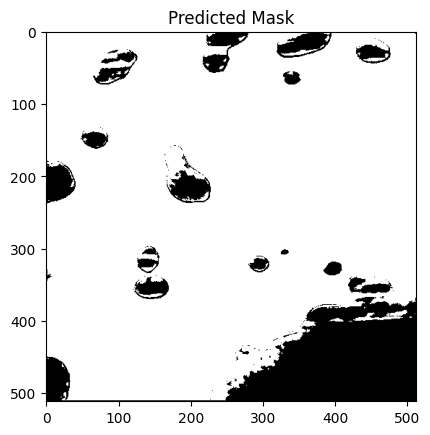

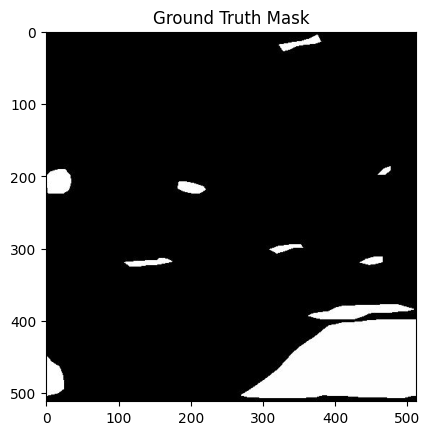

Pixel-wise accuracy: 0.8391799926757812


In [15]:
## evaluating the accuracy of model for specific images

image_path = '/content/drive/My Drive/MASC 515/Project/dataset/images/700.jpg'
image = cv2.imread(image_path)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
plt.imshow(image_rgb)
plt.title("Input Image")
plt.show()

# Load and display the mask
mask_path = '/content/drive/My Drive/MASC 515/Project/dataset/masks/700.jpg'
mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
plt.imshow(mask, cmap='gray')
plt.title("Mask")
plt.show()

preprocess = transforms.Compose([
    transforms.ToTensor(),  # Convert image to tensor
])

# Preprocess the image
image_tensor = preprocess(image_rgb).unsqueeze(0)  # Add a batch dimension

# Convert mask to tensor
mask_tensor = torch.from_numpy(mask).unsqueeze(0).unsqueeze(0)  # Add batch and channel dimensions

# Set the model to evaluation mode
model.eval()

# Forward pass
with torch.no_grad():
    outputs = model(image_tensor)  # Assuming your model expects image_tensor as input

# Compute predictions
_, predicted = torch.max(outputs, 1)  # Assuming your model outputs a tensor with class predictions

# Convert predicted mask tensor to numpy array
predicted_mask = predicted.squeeze(0).cpu().numpy()

# Display the predicted mask
plt.imshow(predicted_mask, cmap='gray')
plt.title("Predicted Mask")
plt.show()

# Compare with ground truth mask (optional)
plt.imshow(mask, cmap='gray')
plt.title("Ground Truth Mask")
plt.show()

#predicted_mask = predicted.squeeze(0).cpu().numpy()
inverted_predicted_mask = 1 - predicted_mask  # Assuming the predicted mask has values 0 and 1

# Compute pixel-wise accuracy
correct_pixels = (inverted_predicted_mask == mask)
accuracy = correct_pixels.sum() / mask.size

print("Pixel-wise accuracy:", accuracy)